# Multitask GP Regression using pymc with GP LatentKron
Data Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [134]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [135]:
train_x.shape, train_y.shape

((50,), (50, 3))

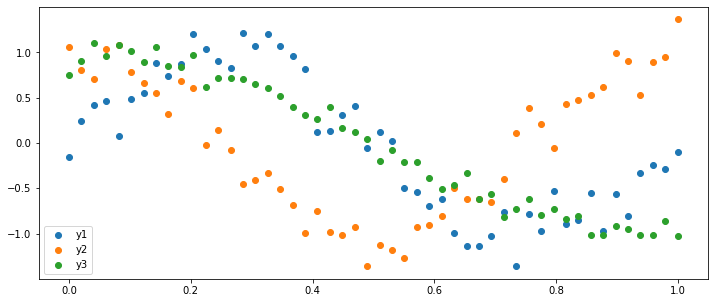

In [136]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [137]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [138]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [139]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [140]:
Xnew = pm.math.cartesian(x, task_i) # For prediction
Xnew.shape

(150, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [141]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [143]:
# with pm.Model() as model:
#     # Kernel: K_1(x,x')
#     ell = pm.Gamma("ell", alpha=2, beta=0.5)
#     eta = pm.Gamma("eta", alpha=3, beta=1)
#     cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
#     # Coregion B matrix: K_2(o,o')
#     W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
#     kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
#     coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
#     cov_func = pm.gp.cov.Kron([cov, coreg])
#     # Specify the GP.  The default mean function is `Zero`.
#     sigma = pm.HalfNormal("sigma", sigma=3)
#     gp = pm.gp.Marginal(cov_func=cov_func)
#     y_ = gp.marginal_likelihood("f", Xs[0], y.squeeze(), noise=sigma)
    
#     # sigma = pm.HalfNormal("sigma", sigma=3)
#     # # Place a GP prior over the function f.
#     # f = mogp.prior("f", Xs=Xs)
#     # y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [144]:
coreg.full(task_i).eval()

array([[ 25.28040614,  25.49734592, -10.56469391],
       [ 25.49734592,  33.98518892, -16.74469893],
       [-10.56469391, -16.74469893,  11.39413291]])

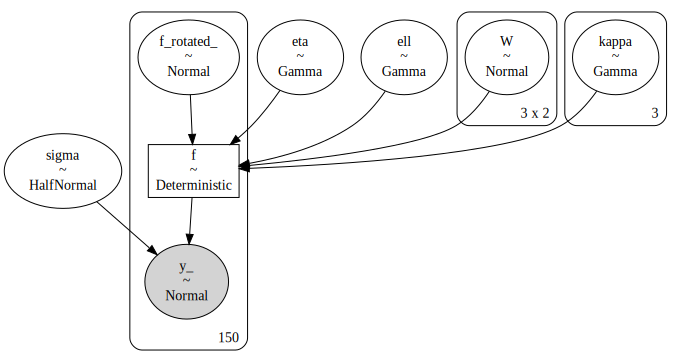

In [145]:
pm.model_to_graphviz(model)

In [146]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 246 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 10min 18s, sys: 22min 7s, total: 32min 25s
Wall time: 4min 10s


#### Prediction

In [147]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

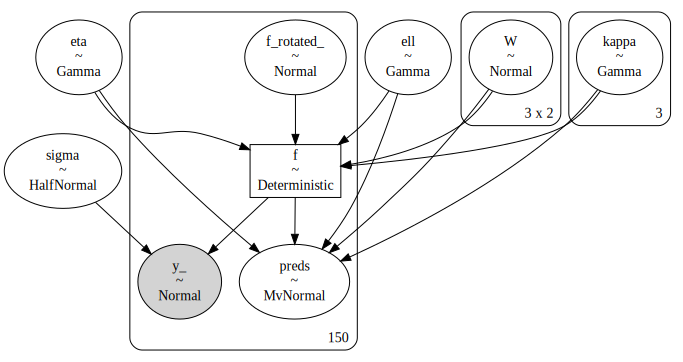

In [148]:
pm.model_to_graphviz(model)

In [149]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 150)

#### Plot the first GP

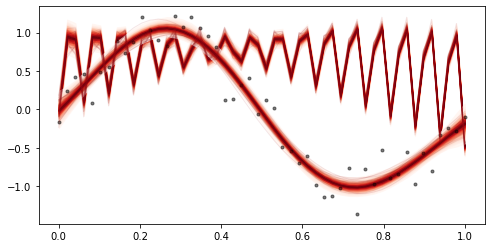

In [155]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], x)
plt.show()
# The result seems wrong!

#### Plot the second GP

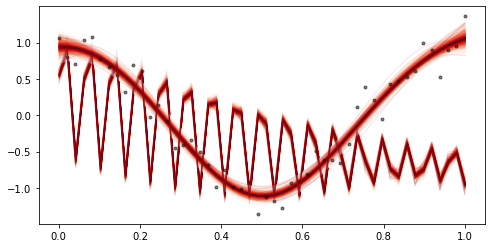

In [156]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], x)
plt.show()

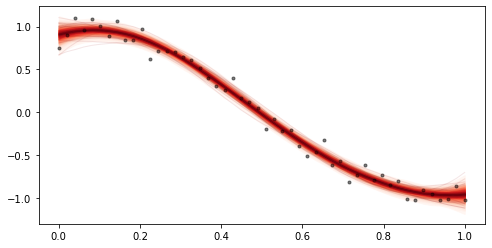

In [158]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 2], x)
plt.show()

### Option2: Implement ICM (one kernel) by using LatentKron with CoregionMatrix

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [159]:
class CoregionMatrix(Covariance):
    r"""
    Coregion Matrix valued covariance function.

    .. math::

       k(x, x') = B(x, x')    """
    
    def __init__(self, W, B):
        super().__init__(1, None)
        self.W = W
        self.B = B

    def diag(self, X):
        return at.alloc(self.B, X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return at.alloc(self.B, X.shape[0], X.shape[0])
        else:
            return at.alloc(self.B, X.shape[0], Xs.shape[0])

In [160]:
# W = np.random.rand(3,2)
# B = W @ W.T + kappa
# B = B + at.identity_like(B)
# coreg = CoregionMatrix(W=W,B=B)

In [161]:
# coreg.full(task_i).eval() == B.eval()

In [162]:
# k = np.random.randn(3,3)
# at.alloc(k, 9,9).eval()

#### Create a model

In [163]:
X.shape

(150, 2)

In [166]:
import aesara.tensor as at

with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = W @ W.T + kappa
    B = B + at.identity_like(B)
    coreg = CoregionMatrix(W=W,B=B)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over the function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [167]:
coreg.full(task_i).eval()

array([[ 8.10482738,  0.39532474, -7.23108036],
       [ 1.27194697,  8.95365866, 15.41631638],
       [-9.11352342, 12.65725109, 42.29269508]])

In [172]:
# pm.model_to_graphviz(model)

In [169]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 36 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.8919, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 1min 26s, sys: 3min 5s, total: 4min 32s
Wall time: 40.8 s


#### Prediction

In [170]:
Xnew.shape

(150, 2)

In [171]:
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

AssertionError: Shapes must be equal
Apply node that caused the error: Assert{msg=Shapes must be equal}(Elemwise{Add}[(0, 1)].0, All.0)
Toposort index: 71
Inputs types: [TensorType(float64, (None, None)), TensorType(bool, ())]
Inputs shapes: [(3, 3), ()]
Inputs strides: [(24, 8), ()]
Inputs values: ['not shown', array(False)]
Outputs clients: [[Elemwise{Composite{(exp((i0 * clip((i1 + i2 + i3), i4, i5))) * i6 * i7)}}[(0, 1)](TensorConstant{(1, 1) of -0.5}, Dot22Scalar.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{x,0}.0, TensorConstant{(1, 1) of 0.0}, TensorConstant{(1, 1) of inf}, Elemwise{sqr,no_inplace}.0, Assert{msg=Shapes must be equal}.0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

#### Plot the first GP

In [ ]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:50], x)
plt.show()
# The result seems wrong!

#### Plot the second GP

In [ ]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 50:100], x)
plt.show()
# The result seems wrong!

In [ ]:
# n_points = 50
# f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
# fig, axes = plt.subplots(3,1, figsize=(8,12))

# for idx in range(3):
#     # plot_gp_dist(axes[idx], f_pred.mean(axis=0)[n_points*idx:n_points*(idx+1)], 
#     #              X_new[n_points*idx:n_points*(idx+1),0], 
#     #              palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
#     axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");
#     axes[idx].plot(x, np.array(f_pred.mean(axis=0)).reshape(-1,1))

In [95]:
X = pm.math.cartesian(x, task_i)
X.shape

(150, 2)

### Option3: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

In [96]:
import aesara.tensor as at
from pymc.math import reduce
from operator import add, mul

class CoregionMatrix(Covariance):
    r"""
    Coregion Matrix valued covariance function.
    .. math::
       k(x, x') = B(x, x')    """
    
    def __init__(self, W, B):
        super().__init__(1, None)
        self.W = W
        self.B = B

    def diag(self, X):
        return at.alloc(self.B, X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return at.alloc(self.B, X.shape[0], X.shape[0])
        else:
            return at.alloc(self.B, X.shape[0], Xs.shape[0])
        
class KronProd(Covariance):
    def __init__(self, factor_list):
        self.input_dims = [factor.input_dim for factor in factor_list]
        input_dim = sum(self.input_dims)
        super().__init__(input_dim=input_dim)
        self.factor_list = factor_list

    def __call__(self, Xl, Xs=None, diag=False):
        covs = [cov(x, xs, diag) for cov, x, xs in zip(self.factor_list, Xl, Xs)]
        return reduce(mul, covs)


In [97]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
#     W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
#     kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
#     B = W @ W.T + kappa
#     B = B + at.identity_like(B)
#     coreg = CoregionMatrix(W=W,B=B)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), testval=np.random.randn(3,2))
    # kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    # coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    cov_func = pm.gp.cov.Kron([cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [98]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [99]:
cov(x).eval().shape, coreg(task_i).eval().shape

((50, 50), (3, 3))

In [100]:
X.shape

(150, 2)

In [101]:
cov_func(X).eval().shape

(150, 150)

In [102]:
X.shape, y.shape

((150, 2), (150, 1))

In [103]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 104 seconds.


CPU times: user 4min 51s, sys: 8min 45s, total: 13min 36s
Wall time: 1min 48s


#### Prediction

In [104]:
Xnew = X #pm.math.cartesian(x, task_i)

In [105]:
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

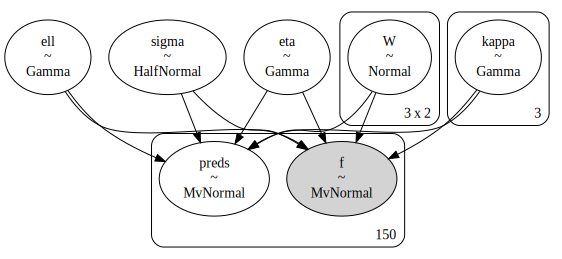

In [106]:
pm.model_to_graphviz(model)

In [111]:
Xnew.shape

(150, 2)

In [107]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 150)

#### Plot the first GP

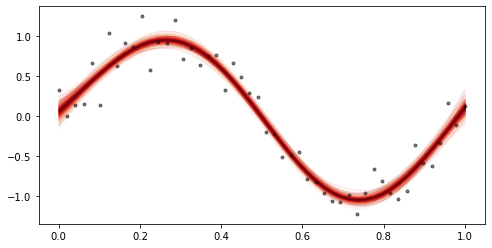

In [130]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
# plot_gp_dist(axes, f_pred[:, 0:50], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], x)

plt.show()
# The result seems wrong!

#### Plot the second GP

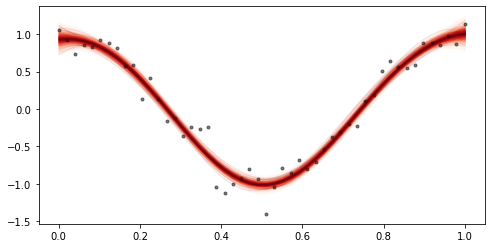

In [131]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], x)
plt.show()

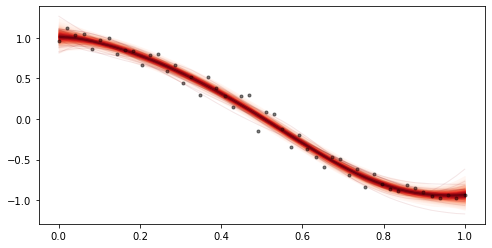

In [133]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 2], x)
plt.show()

In [173]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Sep 02 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

pymc      : 4.1.5
numpy     : 1.22.4
matplotlib: 3.5.2
aesara    : 2.7.9
arviz     : 0.12.1

Watermark: 2.3.0

